In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Contexto
Gregors es un producto B2B2C que se asocia con prestamistas y agencias de verificación de antecedentes para ayudar a completar las necesidades de verificación de ingresos y empleo.

Como parte de este proceso, el usuario final accede al widget de Gregors incrustado en el portal de nuestro cliente o recibe un formulario de pedido por correo electrónico o SMS, donde realiza las siguientes acciones:

1. Buscar a su empleador actual.

2. Cuando un usuario comienza a escribir, utilizamos nuestra base de datos interna de empleadores. Si no se encuentra el empleador, se le presentan los resultados de la API de Google (las dos primeras filas) o la opción de entrada manual (última fila), como se muestra en la captura de pantalla a continuación.

3. Una vez que un usuario selecciona un empleador, puede acceder a la pantalla de inicio de sesión del proveedor de nómina (para empleadores mapeados) o ver una lista de proveedores de nómina.

4. Cuando un usuario envía sus credenciales, recibirá un mensaje de "Éxito" o una notificación de "Error" si su empleo ha sido terminado.



## Objetivo del análisis
El objetivo del análisis a realizar es el siguiente: evaluar la relación entre las variables 'order_has_email' y 'order_has_phone' en función de la tasa de conversión mensual en la casa matriz de la empresa. Además, se buscará comparar estos resultados con las variables de horario para comprender mejor los patrones de comportamiento de los clientes en dicha ubicación (NUEVA YORK).

In [102]:
df = pd.read_csv("gregors.csv")
df.head()

,Client Domain,User Phone Timezone,Created At,Email Clicks,Email Opens,Emails,Expired,Order Funnel State,Sms,Sms Clicks,Sms Opens,Platforms Order Group - Order → Manager,Platforms Order Group - Order → Source,order_has_user_email,order_has_user_phone
0,A,Unknown,2023-03-27T20:44:47.283091Z,0,0,4.0,1,2-Notification sent,0.0,0,0,masked@order_manager.org,internal,True,False
1,A,Unknown,2022-12-02T15:16:41.600287Z,0,3,4.0,1,3-Notification opened,0.0,0,0,masked@order_manager.org,internal,True,False
2,A,Unknown,2023-02-02T14:20:01.939494Z,1,1,1.0,0,8-Submitted login,0.0,0,0,masked@order_manager.org,internal,True,False
3,A,Unknown,2023-03-10T14:14:12.105397Z,3,4,4.0,1,5-Widget loaded,0.0,0,0,masked@order_manager.org,internal,True,False
4,A,Unknown,2023-03-03T22:02:48.992561Z,1,1,1.0,0,8-Submitted login,0.0,0,0,masked@order_manager.org,internal,True,False


## Validación de los datos
Antes de realizar cualquier análisis de un conjunto de datos hay un paso fundamental: validar los datos. Al momento de crear data pipelines, hay que asegurarse de que los datos que van a ser digeridos, procesados y devueltos por dicho proceso de extracción mantengan calidad, exactitud y consistencia. 

Mediante la librería pandas de Python, a continuación, nos aseguraremos que los datos que fueron inputados son exactos, confiables y válidos para hacer un análisis de los mismos.

Pasos a seguir: 

 1. definir las reglas de validación de los datos. Para dicha tarea,    observemos como están compuestas las variables, que tipos de datos contienen y buscar inconsistencias en los valores únicos de alguna columna.
        
       Reglas de validación de datos:
        
        i. Tratamiento de valores faltantes: esencial para garantizar la calidad, integridad y confiabilidad de los resultados del análisis que queremos realizar, que a su vez puede influir en toma de decisiones informadas. En este caso, se puede ver modificada la tasa de conversión.
        ii. Chequear consistencia del funnel comercial: es importante validar que no haya casos donde el flujo lógico de las ventas sea incorrecto. No puede haber notificaciones que se clickearon si ni siquiera se abrieron o incluso enviaron.
        iii. Métricas de Emails y SMS: Además de la consistencia del funnel, se tienen que validar este tipo de métricas. No se deben tomar en cuenta mails o sms que se abrieron pero que no se enviaron al cliente.

Observación general de la validación de los datos antes de adentrarnos en el tratamiento de valores faltantes:

In [103]:
print('El conjunto de datos en cuestión tiene',df.shape[0], 'registros y', df.shape[1], 'campos.')

El conjunto de datos en cuestión tiene 4090 registros y 15 campos.


In [104]:
df.columns

Index(['Client Domain', 'User Phone Timezone', 'Created At', 'Email Clicks',
       'Email Opens', 'Emails', 'Expired', 'Order Funnel State', 'Sms',
       'Sms Clicks', 'Sms Opens', 'Platforms Order Group - Order → Manager',
       'Platforms Order Group - Order → Source', 'order_has_user_email',
       'order_has_user_phone'],
      dtype='object')

In [105]:
for columna in df.columns:
    if columna != 'Created At                  ':
        print(columna, 'tiene los siguientes valores únicos:', sorted(df[columna].unique()))

Client Domain tiene los siguientes valores únicos: ['A']
User Phone Timezone tiene los siguientes valores únicos: ['AST', 'CST', 'EST', 'MST', 'PST', 'UTC-10', 'UTC-9', 'Unknown']
Created At tiene los siguientes valores únicos: ['2022-07-01T13:45:26.373564Z', '2022-07-01T13:46:42.277749Z', '2022-07-01T13:56:39.959732Z', '2022-07-01T13:59:28.525252Z', '2022-07-01T14:14:52.17937Z', '2022-07-01T14:19:13.132563Z', '2022-07-01T14:32:52.854998Z', '2022-07-01T15:10:14.553687Z', '2022-07-01T15:41:15.781466Z', '2022-07-01T16:36:47.286068Z', '2022-07-01T16:54:56.247998Z', '2022-07-01T17:01:24.473175Z', '2022-07-01T17:11:57.407723Z', '2022-07-01T17:35:05.272567Z', '2022-07-01T17:56:30.383081Z', '2022-07-01T18:17:39.903499Z', '2022-07-01T18:34:05.89979Z', '2022-07-01T19:46:21.661866Z', '2022-07-01T21:09:41.184668Z', '2022-07-01T21:11:44.699752Z', '2022-07-05T13:18:30.903503Z', '2022-07-05T13:50:56.864152Z', '2022-07-05T14:01:01.454567Z', '2022-07-05T14:17:29.784387Z', '2022-07-05T14:20:07.390886Z'

In [106]:
for columna in df.columns:
    print(columna, 'tiene',df[columna].nunique(), 'valores únicos.')

Client Domain tiene 1 valores únicos.
User Phone Timezone tiene 8 valores únicos.
Created At tiene 4090 valores únicos.
Email Clicks tiene 5 valores únicos.
Email Opens tiene 5 valores únicos.
Emails tiene 5 valores únicos.
Expired tiene 5 valores únicos.
Order Funnel State tiene 9 valores únicos.
Sms tiene 2 valores únicos.
Sms Clicks tiene 2 valores únicos.
Sms Opens tiene 1 valores únicos.
Platforms Order Group - Order → Manager tiene 1 valores únicos.
Platforms Order Group - Order → Source tiene 1 valores únicos.
order_has_user_email tiene 2 valores únicos.
order_has_user_phone tiene 2 valores únicos.


### Tratamiento de valores faltantes

In [107]:
df1 = df.copy() # Guardamos una copia de los datos original. Se considera una buena práctica dicha acción.

In [108]:
df1.isnull().sum() #Miramos la cantidad de valores faltantes por campo

Client Domain                               0
User Phone Timezone                         0
Created At                                  0
Email Clicks                                0
Email Opens                                 0
Emails                                     16
Expired                                     0
Order Funnel State                          0
Sms                                        16
Sms Clicks                                  0
Sms Opens                                   0
Platforms Order Group - Order → Manager     0
Platforms Order Group - Order → Source      0
order_has_user_email                        0
order_has_user_phone                        0
dtype: int64

Existen valores faltantes, para realizar el tratamiento correcto, no se deben eliminar a primera instancia: primero, se entiende el contexto o se encuentra la causa o la inconsistencia.
Miremos aquellos registros y busquemos particularidades.

In [109]:
df1[df1['Emails'].isna()]

,Client Domain,User Phone Timezone,Created At,Email Clicks,Email Opens,Emails,Expired,Order Funnel State,Sms,Sms Clicks,Sms Opens,Platforms Order Group - Order → Manager,Platforms Order Group - Order → Source,order_has_user_email,order_has_user_phone
16,A,Unknown,2022-12-15T22:36:42.882267Z,0,0,NaN,1,1-Created,NaN,0,0,masked@order_manager.org,internal,False,False
25,A,Unknown,2022-12-28T21:14:26.707105Z,0,0,NaN,1,1-Created,NaN,0,0,masked@order_manager.org,internal,False,False
29,A,Unknown,2022-12-16T14:30:32.075305Z,0,0,NaN,0,1-Created,NaN,0,0,masked@order_manager.org,internal,False,False
121,A,Unknown,2022-12-12T22:09:49.134558Z,0,0,NaN,1,1-Created,NaN,0,0,masked@order_manager.org,internal,False,False
128,A,Unknown,2023-03-20T18:26:43.562093Z,0,0,NaN,1,1-Created,NaN,0,0,masked@order_manager.org,internal,False,False
153,A,Unknown,2022-12-15T22:35:35.176781Z,0,0,NaN,1,1-Created,NaN,0,0,masked@order_manager.org,internal,False,False
317,A,EST,2023-03-20T15:58:16.870337Z,0,0,NaN,0,1-Created,NaN,0,0,masked@order_manager.org,internal,False,True
597,A,EST,2022-07-25T17:18:07.624126Z,0,0,NaN,0,1-Created,NaN,0,0,masked@order_manager.org,internal,True,True
1220,A,CST,2023-03-07T16:41:28.979555Z,0,0,NaN,0,1-Created,NaN,0,0,masked@order_manager.org,internal,False,True
1935,A,EST,2022-07-18T13:44:28.659392Z,0,0,NaN,0,1-Created,NaN,0,0,masked@order_manager.org,internal,True,True


In [110]:
print(round((len(df1[df1['Emails'].isna()]) / len(df1) * 100),2), '% es el porcentaje de filas con valores faltantes respecto al total de registros.')

0.39 % es el porcentaje de filas con valores faltantes respecto al total de registros.


Las 16 filas con valores faltantes tienen como instancia del funnel '1-Created' y representan un porcentaje bajo respecto al tamaño total de los datos. Se procede eliminando dichos registros.

In [111]:
df2 = df1.dropna(subset=['Emails', 'Sms'])
df2.isna().sum() #Efectivamente, no existen más valores faltantes. 

Client Domain                              0
User Phone Timezone                        0
Created At                                 0
Email Clicks                               0
Email Opens                                0
Emails                                     0
Expired                                    0
Order Funnel State                         0
Sms                                        0
Sms Clicks                                 0
Sms Opens                                  0
Platforms Order Group - Order → Manager    0
Platforms Order Group - Order → Source     0
order_has_user_email                       0
order_has_user_phone                       0
dtype: int64

### Tipos de datos

In [112]:
df2.info() #Observamos un resumen de los campos.

<class 'pandas.core.frame.DataFrame'>
Index: 4074 entries, 0 to 4089
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Client Domain                            4074 non-null   object 
 1   User Phone Timezone                      4074 non-null   object 
 2   Created At                               4074 non-null   object 
 3   Email Clicks                             4074 non-null   int64  
 4   Email Opens                              4074 non-null   int64  
 5   Emails                                   4074 non-null   float64
 6   Expired                                  4074 non-null   int64  
 7   Order Funnel State                       4074 non-null   object 
 8   Sms                                      4074 non-null   float64
 9   Sms Clicks                               4074 non-null   int64  
 10  Sms Opens                                4074 non-nul

### Consistencia del funnel comercial

In [113]:
df2['Order Funnel State'].unique() #Es de tipo objeto, ergo, no puedo filtrar por etapa del funnel si es que quiero.

array(['2-Notification sent', '3-Notification opened',
       '8-Submitted login', '5-Widget loaded', '4-Notification click',
       '9-Completed', '6-Employer selected', '7-Viewed provider login'],
      dtype=object)

In [114]:
#Nos quedamos únicamente con el número del funnel.
df2['etapa_del_funnel'] = df2['Order Funnel State'].apply(lambda x: int(x.split('-')[0]))
sorted(df2['etapa_del_funnel'].unique())

C:\Users\juanf\AppData\Local\Temp\ipykernel_19548\535437598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['etapa_del_funnel'] = df2['Order Funnel State'].apply(lambda x: int(x.split('-')[0]))


[2, 3, 4, 5, 6, 7, 8, 9]

In [115]:
sorted(df2['Order Funnel State'].unique())

['2-Notification sent',
 '3-Notification opened',
 '4-Notification click',
 '5-Widget loaded',
 '6-Employer selected',
 '7-Viewed provider login',
 '8-Submitted login',
 '9-Completed']

### Inconsistencias en métricas de SMS y Emails

Como hemos mencionado al principio, habría inconsistencias si existen registros donde ya se han abierto notificaciones (etapa 3) pero figuran sin emails abiertos por ejemplo. 

Otra inconsistencia posible a considerar es que se haya registros que estén en etapas mayores a 3 (a partir de 4 se clickearon) y no haya clicks en emails.

1. Inconsistencias en correos enviados
2. Inconsistencias en sms enviados

In [116]:
# 1 Inconsistencias en correos enviados.

In [117]:
correos_ya_enviados = df2.groupby(['etapa_del_funnel', 'Emails']).agg(
    cantidad_de_emails_abiertos = ('Email Opens', 'sum'),
    cantidad_de_emails_clicks = ('Email Clicks', 'sum')
).reset_index()
correos_ya_enviados

,etapa_del_funnel,Emails,cantidad_de_emails_abiertos,cantidad_de_emails_clicks
0,2,0.0,0,0
1,2,1.0,0,0
2,2,2.0,0,0
3,2,4.0,0,0
4,3,1.0,2,0
5,3,4.0,409,0
6,4,0.0,0,0
7,4,1.0,2,3
8,4,4.0,29,6
9,5,0.0,0,0


In [118]:
sms_ya_enviados = df2.groupby(['etapa_del_funnel', 'Sms']).agg(
    cantidad_de_sms_abiertos = ('Sms Opens', 'sum'),
    cantidad_de_sms_clicks = ('Sms Clicks', 'sum')
).reset_index()
sms_ya_enviados

,etapa_del_funnel,Sms,cantidad_de_sms_abiertos,cantidad_de_sms_clicks
0,2,0.0,0,0
1,2,1.0,0,0
2,3,0.0,0,0
3,3,1.0,0,0
4,4,0.0,0,0
5,4,1.0,0,129
6,5,0.0,0,0
7,5,1.0,0,267
8,6,0.0,0,0
9,6,1.0,0,335


Se observan inconsistencias, hay filas donde dice que se enviaron mail (por la etapa en que están (>2)) pero figuran con emails_sent igual a 0.

In [119]:
filas_con_inconsistencias = df2[(df2['Email Opens'] == 0) & (df2['Sms Opens'] == 0) & (df2['etapa_del_funnel'] > 2)]
filas_con_inconsistencias

,Client Domain,User Phone Timezone,Created At,Email Clicks,Email Opens,Emails,Expired,Order Funnel State,Sms,Sms Clicks,Sms Opens,Platforms Order Group - Order → Manager,Platforms Order Group - Order → Source,order_has_user_email,order_has_user_phone,etapa_del_funnel
78,A,Unknown,2022-10-28T14:27:19.596959Z,1,0,1.0,0,4-Notification click,0.0,0,0,masked@order_manager.org,internal,True,False,4
146,A,Unknown,2022-09-14T16:09:45.450499Z,2,0,4.0,1,7-Viewed provider login,0.0,0,0,masked@order_manager.org,internal,True,False,7
194,A,EST,2023-01-20T19:03:11.624372Z,2,0,4.0,1,6-Employer selected,1.0,1,0,masked@order_manager.org,internal,True,True,6
199,A,EST,2022-10-06T15:17:54.164108Z,0,0,0.0,1,6-Employer selected,1.0,1,0,masked@order_manager.org,internal,False,True,6
200,A,EST,2022-12-12T14:24:39.440022Z,0,0,1.0,0,8-Submitted login,1.0,1,0,masked@order_manager.org,internal,True,True,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4033,A,CST,2022-07-14T18:19:03.889063Z,0,0,4.0,1,8-Submitted login,1.0,1,0,masked@order_manager.org,internal,True,True,8
4034,A,CST,2022-08-18T20:30:09.688551Z,0,0,0.0,1,7-Viewed provider login,1.0,1,0,masked@order_manager.org,internal,False,True,7
4035,A,EST,2022-10-27T18:09:06.743787Z,0,0,0.0,1,7-Viewed provider login,1.0,1,0,masked@order_manager.org,internal,False,True,7
4036,A,EST,2023-02-28T16:42:12.938568Z,0,0,0.0,1,4-Notification click,1.0,1,0,masked@order_manager.org,internal,False,True,4


Falta ver aquellas inconsistencias que involucren registros sin clicks en sms y emails y cuyo etapa del funnel sea mayor o igual a la 4ta (Click de notificación)

In [120]:
filas_con_inconsistencias_2 = df2[((df2['etapa_del_funnel'] >= 4) & (df2['Email Clicks'] == 0) & (df2['Sms Clicks'] == 0))]
filas_con_inconsistencias_2

,Client Domain,User Phone Timezone,Created At,Email Clicks,Email Opens,Emails,Expired,Order Funnel State,Sms,Sms Clicks,Sms Opens,Platforms Order Group - Order → Manager,Platforms Order Group - Order → Source,order_has_user_email,order_has_user_phone,etapa_del_funnel
164,A,Unknown,2022-09-02T21:31:54.085502Z,0,4,4.0,1,7-Viewed provider login,0.0,0,0,masked@order_manager.org,internal,True,False,7
179,A,Unknown,2022-09-08T17:48:28.880669Z,0,2,4.0,1,6-Employer selected,0.0,0,0,masked@order_manager.org,internal,True,False,6
1483,A,EST,2022-07-05T14:49:39.580578Z,0,3,4.0,1,7-Viewed provider login,1.0,0,0,masked@order_manager.org,internal,True,True,7
1613,A,CST,2022-08-12T20:12:05.020255Z,0,3,4.0,1,6-Employer selected,1.0,0,0,masked@order_manager.org,internal,True,True,6


Las inconsistencias identificadas tienen un impacto directo en la tasa de conversión, ya que pueden distorsionar los resultados y dificultar la comprensión del comportamiento de los clientes. 

Además, comprometen la calidad del análisis al introducir sesgos y limitar la precisión de las conclusiones. Es esencial abordar y corregir estas inconsistencias para garantizar que el análisis sea sólido y las decisiones se basen en datos confiables.

In [121]:
sorted(df2['Order Funnel State'].unique())

['2-Notification sent',
 '3-Notification opened',
 '4-Notification click',
 '5-Widget loaded',
 '6-Employer selected',
 '7-Viewed provider login',
 '8-Submitted login',
 '9-Completed']

In [122]:
filas_sin_inconsistencias = df2[~((df2['etapa_del_funnel'] > 2) & (df2['Email Clicks'] == 0) & (df2['Sms Clicks'] == 0))]
filas_sin_inconsistencias_de_sms = filas_sin_inconsistencias[~((filas_sin_inconsistencias['Sms Clicks'] > 0) & (filas_sin_inconsistencias['Sms Opens'] == 0))]
filas_sin_inconsistencias_de_sms_y_emails = filas_sin_inconsistencias_de_sms[~((filas_sin_inconsistencias_de_sms['Email Clicks'] > 0) & (filas_sin_inconsistencias_de_sms['Email Opens'] == 0))]
print(f'El dataframe original contiene {len(df2)} filas y el nuevo dataframe contiene {len(filas_sin_inconsistencias_de_sms_y_emails)}')
print(f'El dataframe nuevo, sin inconsistencias, es el {round((len(df2) - len(filas_sin_inconsistencias_de_sms_y_emails)) / len(df2) * 100,2)} % del original.')

El dataframe original contiene 4074 filas y el nuevo dataframe contiene 1457
El dataframe nuevo, sin inconsistencias, es el 64.24 % del original.


### Aclaración

Si este hubiese sido otro dataset, se compararían tasas de conversión (u otro tipo de KPI) de forma comparativa, entre el dataframe con y sin inconsistencias. 

En este caso, voy a estar usando el dataframe con inconsistencias porque este análisis ya se había hecho y se llegó a la conclusión de que las inconsistencias capturadas habían sido resultado de una ventana específica de tiempo en los datos. Es decir, faltaba más información que no teníamos al alcance y por ende se siguió el análisis exploratorio con los datos CON inconsistencias ya que no se encontraron cambios significativos en la tasa de conversión hasta antes del 2023.

## Tasa de conversión general (sin filtro alguno)
Se comparará la tasa de conversión a lo largo del tiempo, para entender cómo vienen cerrando ventas en el departamento comercial de la empresa. 
Primero, se manipularán las columnas con fecha que no están en dicho formato todavía.

C:\Users\juanf\AppData\Local\Temp\ipykernel_19548\2320725977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Created At'] = pd.to_datetime(df2['Created At'])
C:\Users\juanf\AppData\Local\Temp\ipykernel_19548\2320725977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Day'] = df2['Created At'].dt.day
C:\Users\juanf\AppData\Local\Temp\ipykernel_19548\2320725977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

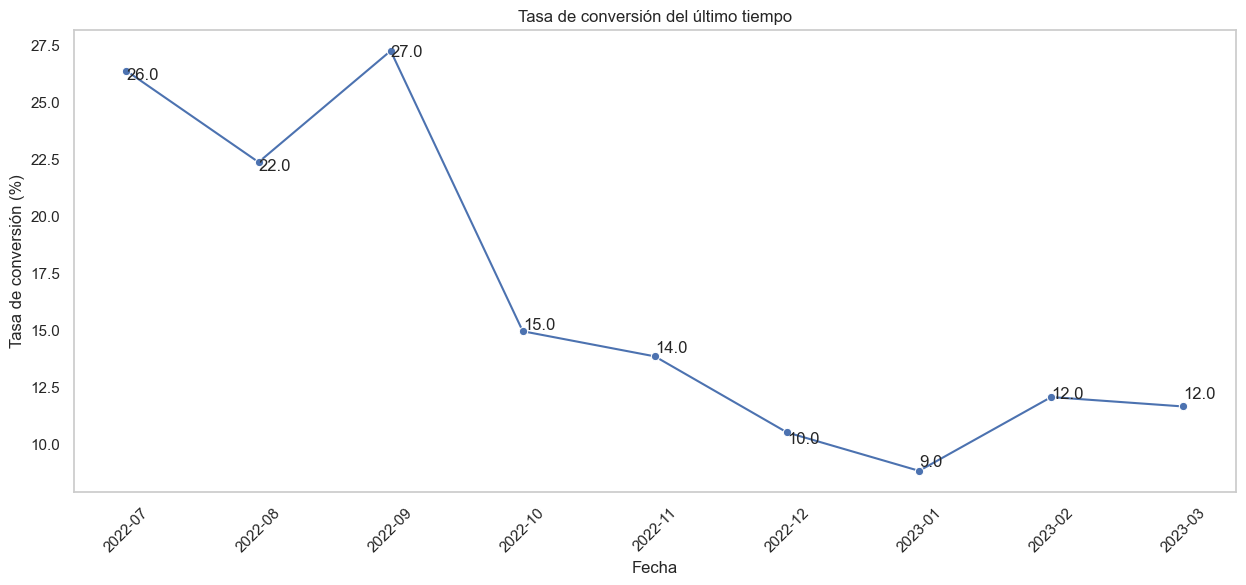

In [123]:
df2['Created At'] = pd.to_datetime(df2['Created At'])
df2['Day'] = df2['Created At'].dt.day
df2['Month'] = df2['Created At'].dt.month
df2['Year'] = df2['Created At'].dt.year
def plot_conversion_rate(df, title):
    completed_df = df[df['Order Funnel State'] == '9-Completed']
    completed_grouped = completed_df.groupby(['Year', 'Month']).size().reset_index(name='Completed_Count')
    total_grouped = df.groupby(['Year', 'Month']).size().reset_index(name='Total_Count')
    conversion_df = pd.merge(total_grouped, completed_grouped, on=['Year', 'Month'], how='left').fillna(0)
    conversion_df['Conversion_Rate'] = (conversion_df['Completed_Count'] / conversion_df['Total_Count']) * 100
    conversion_df['Year_Month'] = conversion_df['Year'].astype(str) + '-' + conversion_df['Month'].astype(str).str.zfill(2)
    
    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i,round(y[i],0),round(y[i],0))
    x = conversion_df['Year_Month']
    y = conversion_df['Conversion_Rate']
    plt.figure(figsize=(15, 6))
    sns.set(style="whitegrid")
    sns.lineplot(x='Year_Month', y='Conversion_Rate', data=conversion_df, marker='o')
    plt.title(title)
    plt.xlabel('Fecha')
    addlabels(x,y)
    plt.ylabel('Tasa de conversión (%)')
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.show()
plot_conversion_rate(df2, 'Tasa de conversión del último tiempo')

## Comparación de variables order_has_email y order_has_phone
### 1. Manipulación de variable 'User Phone Timezone'
 - Una buena hipótesis es investigar si la time zone de dichos clientes contactados tiene un impacto significativo en las tasas de conversión. 
 - Dicho esto, se mapearán las timezones a sus debidos formatos de manera tal que cada zona geográfica pueda ser comparable con la timezone del cliente.

In [124]:
df2["User Phone Timezone"].value_counts().sort_values(ascending=False)

User Phone Timezone
CST        2357
EST        1277
Unknown     242
PST         128
MST          54
AST           8
UTC-10        5
UTC-9         3
Name: count, dtype: int64

In [125]:
df_tz = df2[df2["User Phone Timezone"]!= "Unknown"]
timezone_format = {'EST':'America/New_York', 
            'CST':'America/Chicago', 
            'PST':'America/Los_Angeles',
            'MST':'America/Denver',
            'AST':'America/Puerto_Rico',
                   'UTC-10':'Pacific/Honolulu',
                     'UTC-9':'America/Anchorage'
                   }
df_tz['hrs-pyz'] = df_tz["User Phone Timezone"].map(timezone_format)

C:\Users\juanf\AppData\Local\Temp\ipykernel_19548\2453268675.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tz['hrs-pyz'] = df_tz["User Phone Timezone"].map(timezone_format)


In [126]:
df_tz['hrs-pyz'].unique()

array(['America/New_York', 'America/Chicago', 'America/Los_Angeles',
       'America/Denver', 'America/Puerto_Rico', 'Pacific/Honolulu',
       'America/Anchorage'], dtype=object)

In [127]:
df_tz['hrs-pyz'].value_counts().sort_values(ascending=False)

hrs-pyz
America/Chicago        2357
America/New_York       1277
America/Los_Angeles     128
America/Denver           54
America/Puerto_Rico       8
Pacific/Honolulu          5
America/Anchorage         3
Name: count, dtype: int64

Conversión de horario a la timezone del cliente

In [128]:
import pytz
import pandas as pd
def convert_to_local_time(row):
    try:
        if pd.isnull(row['Created At']) or row['User Phone Timezone'] is None:
            return row['Created At']
        
        local_tz = pytz.timezone(row['hrs-pyz'])
        
        if row['Created At'].tzinfo is not None:
            local_time = row['Created At'].astimezone(local_tz)
        else:  
            utc_time = pytz.utc.localize(row['Created At'])
            local_time = utc_time.astimezone(local_tz)
        
        return local_time
    except Exception as e:
        print(f"Row with error {row['Created At']} -> to {row['hrs-pyz']}")
        return row['Created At']
    
df_tz['local_time'] = df_tz.apply(convert_to_local_time, axis=1)
df_tz

C:\Users\juanf\AppData\Local\Temp\ipykernel_19548\1314867726.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tz['local_time'] = df_tz.apply(convert_to_local_time, axis=1)


,Client Domain,User Phone Timezone,Created At,Email Clicks,Email Opens,Emails,Expired,Order Funnel State,Sms,Sms Clicks,...,Platforms Order Group - Order → Manager,Platforms Order Group - Order → Source,order_has_user_email,order_has_user_phone,etapa_del_funnel,Day,Month,Year,hrs-pyz,local_time
194,A,EST,2023-01-20 19:03:11.624372+00:00,2,0,4.0,1,6-Employer selected,1.0,1,...,masked@order_manager.org,internal,True,True,6,20,1,2023,America/New_York,2023-01-20 14:03:11.624372-05:00
195,A,EST,2022-07-12 17:44:08.149542+00:00,1,1,1.0,0,9-Completed,1.0,1,...,masked@order_manager.org,internal,True,True,9,12,7,2022,America/New_York,2022-07-12 13:44:08.149542-04:00
196,A,EST,2022-08-08 20:24:56.757669+00:00,1,1,1.0,0,9-Completed,1.0,0,...,masked@order_manager.org,internal,True,True,9,8,8,2022,America/New_York,2022-08-08 16:24:56.757669-04:00
197,A,EST,2022-11-28 17:32:59.758117+00:00,0,4,4.0,1,7-Viewed provider login,1.0,1,...,masked@order_manager.org,internal,True,True,7,28,11,2022,America/New_York,2022-11-28 12:32:59.758117-05:00
198,A,EST,2022-07-07 15:39:00.538025+00:00,4,4,4.0,1,5-Widget loaded,1.0,1,...,masked@order_manager.org,internal,True,True,5,7,7,2022,America/New_York,2022-07-07 11:39:00.538025-04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4032,A,CST,2022-07-18 18:21:37.529621+00:00,1,1,4.0,1,7-Viewed provider login,1.0,0,...,masked@order_manager.org,internal,True,True,7,18,7,2022,America/Chicago,2022-07-18 13:21:37.529621-05:00
4033,A,CST,2022-07-14 18:19:03.889063+00:00,0,0,4.0,1,8-Submitted login,1.0,1,...,masked@order_manager.org,internal,True,True,8,14,7,2022,America/Chicago,2022-07-14 13:19:03.889063-05:00
4034,A,CST,2022-08-18 20:30:09.688551+00:00,0,0,0.0,1,7-Viewed provider login,1.0,1,...,masked@order_manager.org,internal,False,True,7,18,8,2022,America/Chicago,2022-08-18 15:30:09.688551-05:00
4035,A,EST,2022-10-27 18:09:06.743787+00:00,0,0,0.0,1,7-Viewed provider login,1.0,1,...,masked@order_manager.org,internal,False,True,7,27,10,2022,America/New_York,2022-10-27 14:09:06.743787-04:00


Otro punto a analizar y transformar es el de la hora contactada de la notificación.

In [129]:
def check_hour(horario):
    horario = str(horario)
    return horario.split(" ")[1].split(":")[0]
df_tz['local_time_apply'] = df_tz['local_time'].apply(check_hour)

C:\Users\juanf\AppData\Local\Temp\ipykernel_19548\987549172.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tz['local_time_apply'] = df_tz['local_time'].apply(check_hour)


In [130]:
df_tz['local_time_apply'] = df_tz['local_time_apply'].astype(int)

C:\Users\juanf\AppData\Local\Temp\ipykernel_19548\2750846577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tz['local_time_apply'] = df_tz['local_time_apply'].astype(int)


Se creará una columna con booleano de conversión para facilitar el análisis exploratorio.

In [131]:
df_tz["conversion"] = df_tz['Order Funnel State'] == "9-Completed" #Aquellas ventas concretadas.

df_tz["conversion"] = df_tz["conversion"].astype(int) # Lo llevo a binario de enteros.

conv_df = df_tz.groupby('local_time_apply', as_index=True).agg(cant_conversion = ("conversion","sum"),
                                       totales = ("conversion","count") ) 

conv_df["%_conversion"] = conv_df["cant_conversion"]/conv_df["totales"] #Pasamos a porcentaje las conversiones totales.
conv_df

C:\Users\juanf\AppData\Local\Temp\ipykernel_19548\2052848709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tz["conversion"] = df_tz['Order Funnel State'] == "9-Completed" #Aquellas ventas concretadas.
C:\Users\juanf\AppData\Local\Temp\ipykernel_19548\2052848709.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tz["conversion"] = df_tz["conversion"].astype(int) # Lo llevo a binario de enteros.


,cant_conversion,totales,%_conversion
local_time_apply,,,
4,1,1,1.000000
5,0,2,0.000000
6,5,20,0.250000
7,2,20,0.100000
8,37,213,0.173709
9,72,413,0.174334
10,74,468,0.158120
11,48,339,0.141593
12,73,414,0.176329


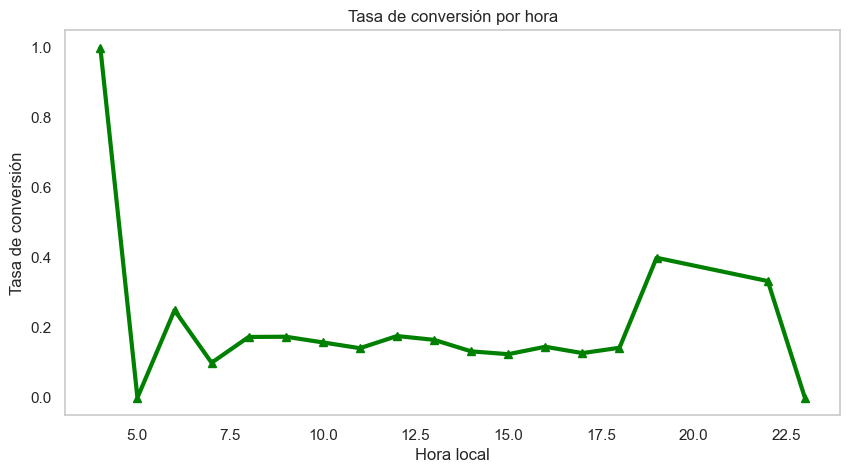

In [132]:
conv_df = conv_df.sort_index()
plt.figure(figsize=(10,5))
plt.plot(conv_df.index, conv_df['%_conversion'], marker='^', linewidth=3, color='green')
plt.title('Tasa de conversión por hora')
plt.xlabel('Hora local')
plt.ylabel('Tasa de conversión')
plt.grid(False)
plt.show()

In [133]:
conv_df_by_tz = df_tz.groupby(['hrs-pyz','local_time_apply'], as_index=True).agg(cant_conversion = ("conversion","sum"),
                                       totales = ("conversion","count") )
conv_df_by_tz["%_conversion"] = conv_df_by_tz["cant_conversion"]/conv_df_by_tz["totales"]
conv_df_by_tz

cant_conversion  totales  %_conversion
hrs-pyz             local_time_apply                                        
America/Anchorage   5                               0        1      0.000000
                    7                               0        1      0.000000
                    13                              0        1      0.000000
America/Chicago     7                               0        2      0.000000
                    8                              35      191      0.183246
                    9                              40      281      0.142349
                    10                             32      299      0.107023
                    11                             30      178      0.168539
                    12                             47      251      0.187251
                    13                             35      231      0.151515
                    14                             34      248      0.137097
                    15                             40      338      0.118343
                    16                             37      282      0.131206
                    17                              9       47      0.191489
                    18                              0        7      0.000000
                    22                              1        2      0.500000
America/Denver      7                               0        4      0.000000
                    8                               1        6      0.166667
                    9                               2        8      0.250000
                    10                              2        4      0.500000
                    11                              3        5      0.600000
                    12                              1        8      0.125000
                    13                              0        6      0.000000
                    14                              0        9      0.000000
                    15                              0        4      0.000000
America/Los_Angeles 5                               0        1      0.000000
                    6                               5       19      0.263158
                    7                               2       13      0.153846
                    8                               1       16      0.062500
                    9                               1       14      0.071429
                    10                              2       13      0.153846
                    11                              1       10      0.100000
                    12                              1       11      0.090909
                    13                              1       12      0.083333
                    14                              1       19      0.052632
America/New_York    9                              29      110      0.263636
                    10                             37      150      0.246667
                    11                             14      141      0.099291
                    12                             24      143      0.167832
                    13                             30      149      0.201342
                    14                             20      139      0.143885
                    15                             21      148      0.141892
                    16                             22      122      0.180328
                    17                             16      147      0.108844
                    18                              4       21      0.190476
                    19                              2        5      0.400000
                    22                              0        1      0.000000
                    23                              0        1      0.000000
America/Puerto_Rico 10                              1        2      0.500000
                    11                              0        2      0.000000
                    12            

### Nos adentramos en el análisis principal: evaluar la relación entre las variables 'order_has_email' y 'order_has_phone' en función de la tasa de conversión mensual.

In [134]:
conv_df_by_tz = df_tz.groupby(['hrs-pyz','local_time_apply'], as_index=True).agg(cant_conversion = ("conversion","sum"),
                                       totales = ("conversion","count") )
conv_df_by_tz["%_conversion"] = conv_df_by_tz["cant_conversion"]/conv_df_by_tz["totales"]
conv_df_by_tz

cant_conversion  totales  %_conversion
hrs-pyz             local_time_apply                                        
America/Anchorage   5                               0        1      0.000000
                    7                               0        1      0.000000
                    13                              0        1      0.000000
America/Chicago     7                               0        2      0.000000
                    8                              35      191      0.183246
                    9                              40      281      0.142349
                    10                             32      299      0.107023
                    11                             30      178      0.168539
                    12                             47      251      0.187251
                    13                             35      231      0.151515
                    14                             34      248      0.137097
                    15                             40      338      0.118343
                    16                             37      282      0.131206
                    17                              9       47      0.191489
                    18                              0        7      0.000000
                    22                              1        2      0.500000
America/Denver      7                               0        4      0.000000
                    8                               1        6      0.166667
                    9                               2        8      0.250000
                    10                              2        4      0.500000
                    11                              3        5      0.600000
                    12                              1        8      0.125000
                    13                              0        6      0.000000
                    14                              0        9      0.000000
                    15                              0        4      0.000000
America/Los_Angeles 5                               0        1      0.000000
                    6                               5       19      0.263158
                    7                               2       13      0.153846
                    8                               1       16      0.062500
                    9                               1       14      0.071429
                    10                              2       13      0.153846
                    11                              1       10      0.100000
                    12                              1       11      0.090909
                    13                              1       12      0.083333
                    14                              1       19      0.052632
America/New_York    9                              29      110      0.263636
                    10                             37      150      0.246667
                    11                             14      141      0.099291
                    12                             24      143      0.167832
                    13                             30      149      0.201342
                    14                             20      139      0.143885
                    15                             21      148      0.141892
                    16                             22      122      0.180328
                    17                             16      147      0.108844
                    18                              4       21      0.190476
                    19                              2        5      0.400000
                    22                              0        1      0.000000
                    23                              0        1      0.000000
America/Puerto_Rico 10                              1        2      0.500000
                    11                              0        2      0.000000
                    12            

In [135]:
df_tz.columns

Index(['Client Domain', 'User Phone Timezone', 'Created At', 'Email Clicks',
       'Email Opens', 'Emails', 'Expired', 'Order Funnel State', 'Sms',
       'Sms Clicks', 'Sms Opens', 'Platforms Order Group - Order → Manager',
       'Platforms Order Group - Order → Source', 'order_has_user_email',
       'order_has_user_phone', 'etapa_del_funnel', 'Day', 'Month', 'Year',
       'hrs-pyz', 'local_time', 'local_time_apply', 'conversion'],
      dtype='object')

In [136]:
df_tz['conversion'].unique()

array([0, 1])

In [137]:
df_tz['order_has_user_phone'].unique()

array([ True])

In [138]:
df_tz['order_has_user_email'].unique()

array([ True, False])

In [139]:
df2['order_has_user_phone'].unique()

array([False,  True])

In [140]:
convertidos_df_tz = df_tz.groupby(['hrs-pyz','local_time_apply'], as_index=True).agg(
    conversiones = ('conversion', 'sum'),
    totales = ('conversion', 'count')
)

convertidos_df_tz["%_conversion"] = convertidos_df_tz["conversiones"]/convertidos_df_tz["totales"]
convertidos_df_tz

conversiones  totales  %_conversion
hrs-pyz             local_time_apply                                     
America/Anchorage   5                            0        1      0.000000
                    7                            0        1      0.000000
                    13                           0        1      0.000000
America/Chicago     7                            0        2      0.000000
                    8                           35      191      0.183246
                    9                           40      281      0.142349
                    10                          32      299      0.107023
                    11                          30      178      0.168539
                    12                          47      251      0.187251
                    13                          35      231      0.151515
                    14                          34      248      0.137097
                    15                          40      338      0.118343
                    16                          37      282      0.131206
                    17                           9       47      0.191489
                    18                           0        7      0.000000
                    22                           1        2      0.500000
America/Denver      7                            0        4      0.000000
                    8                            1        6      0.166667
                    9                            2        8      0.250000
                    10                           2        4      0.500000
                    11                           3        5      0.600000
                    12                           1        8      0.125000
                    13                           0        6      0.000000
                    14                           0        9      0.000000
                    15                           0        4      0.000000
America/Los_Angeles 5                            0        1      0.000000
                    6                            5       19      0.263158
                    7                            2       13      0.153846
                    8                            1       16      0.062500
                    9                            1       14      0.071429
                    10                           2       13      0.153846
                    11                           1       10      0.100000
                    12                           1       11      0.090909
                    13                           1       12      0.083333
                    14                           1       19      0.052632
America/New_York    9                           29      110      0.263636
                    10                          37      150      0.246667
                    11                          14      141      0.099291
                    12                          24      143      0.167832
                    13                          30      149      0.201342
                    14                          20      139      0.143885
                    15                          21      148      0.141892
                    16                          22      122      0.180328
                    17                          16      147      0.108844
                    18                           4       21      0.190476
                    19                           2        5      0.400000
                    22                           0        1      0.000000
                    23                           0        1      0.000000
America/Puerto_Rico 10                           1        2      0.500000
                    11                           0        2      0.000000
                    12                           0        1      0.000000
                    16                           0        1      0.000000
                    17                    

## Asumimos
Hacemos de cuenta en este caso, que la casa matriz es la de Nueva York, en Estados Unidos. Para dicho objetivo, filtramos esta última agrupación en esta ciudad.

In [141]:
convertidos_df_tz.columns

Index(['conversiones', 'totales', '%_conversion'], dtype='object')

In [142]:
df_tz['hrs-pyz'].unique()

array(['America/New_York', 'America/Chicago', 'America/Los_Angeles',
       'America/Denver', 'America/Puerto_Rico', 'Pacific/Honolulu',
       'America/Anchorage'], dtype=object)

In [143]:
df_resumido = df_tz[['hrs-pyz','local_time_apply','order_has_user_phone', 'order_has_user_email', 'conversion']]
ny = df_resumido[df_resumido['hrs-pyz'] == 'America/New_York']
ny

,hrs-pyz,local_time_apply,order_has_user_phone,order_has_user_email,conversion
194,America/New_York,14,True,True,0
195,America/New_York,13,True,True,1
196,America/New_York,16,True,True,1
197,America/New_York,12,True,True,0
198,America/New_York,11,True,True,0
...,...,...,...,...,...
4029,America/New_York,17,True,True,0
4030,America/New_York,11,True,True,0
4031,America/New_York,17,True,False,1
4035,America/New_York,14,True,False,0


### Grafiquemos la tasa de conversión mensual del último tiempo en NY y de la compañía

In [144]:
NuevaYorkCompleto = df_tz[df_tz['hrs-pyz'] == 'America/New_York']

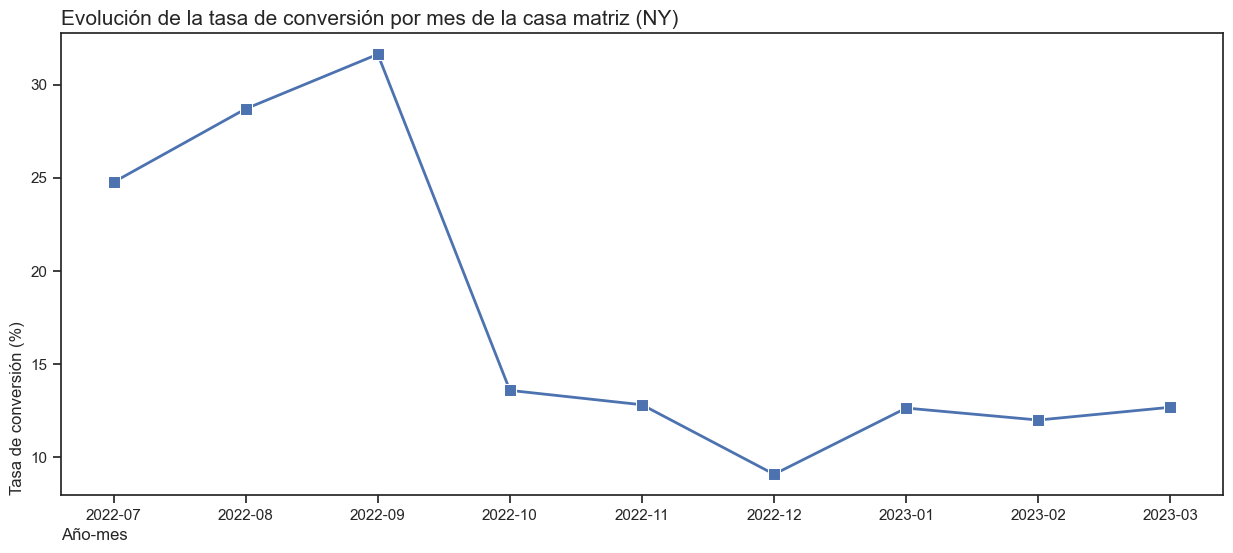

In [145]:
def plot_conversion_rate_casa_matriz(df, title):
    completed_df = df[df['Order Funnel State'] == '9-Completed']
    completed_grouped = completed_df.groupby(['Year', 'Month']).size().reset_index(name='Completed_Count')
    total_grouped = df.groupby(['Year', 'Month']).size().reset_index(name='Total_Count')
    conversion_df = pd.merge(total_grouped, completed_grouped, on=['Year', 'Month'], how='left').fillna(0)
    conversion_df['Conversion_Rate'] = (conversion_df['Completed_Count'] / conversion_df['Total_Count']) * 100
    conversion_df['Year_Month'] = conversion_df['Year'].astype(str) + '-' + conversion_df['Month'].astype(str).str.zfill(2)
    plt.figure(figsize=(15, 6))
    sns.set(style="ticks")
    sns.lineplot(x='Year_Month', y='Conversion_Rate', data=conversion_df,lw=2, marker='s',ms=9)
    plt.title(title,loc='left',fontsize=15)
    plt.xlabel('Año-mes',loc='left')
    plt.ylabel('Tasa de conversión (%)', loc='bottom')
    plt.xticks(rotation=0)
    plt.grid(False)
    plt.show()
plot_conversion_rate_casa_matriz(NuevaYorkCompleto, 'Evolución de la tasa de conversión por mes de la casa matriz (NY)')

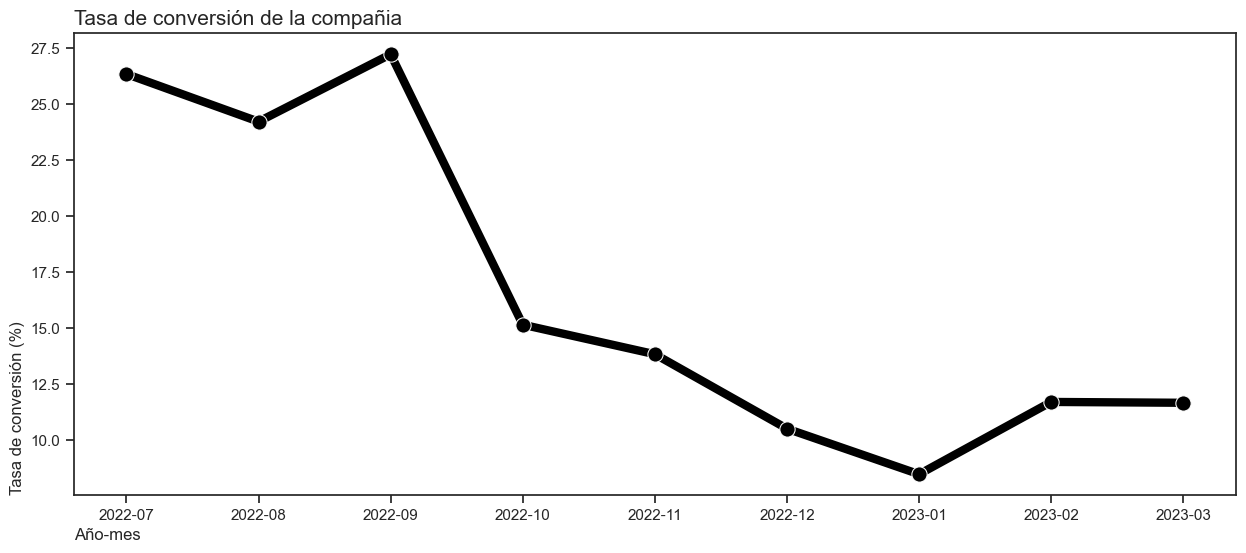

In [146]:
def plot_conversion_rate_new(df, title):
    completed_df = df[df['Order Funnel State'] == '9-Completed']
    completed_grouped = completed_df.groupby(['Year', 'Month']).size().reset_index(name='Completed_Count')
    total_grouped = df.groupby(['Year', 'Month']).size().reset_index(name='Total_Count')
    conversion_df = pd.merge(total_grouped, completed_grouped, on=['Year', 'Month'], how='left').fillna(0)
    conversion_df['Conversion_Rate'] = (conversion_df['Completed_Count'] / conversion_df['Total_Count']) * 100
    conversion_df['Year_Month'] = conversion_df['Year'].astype(str) + '-' + conversion_df['Month'].astype(str).str.zfill(2)
    
    plt.figure(figsize=(15, 6))
    sns.set(style="ticks")
    sns.lineplot(x='Year_Month', y='Conversion_Rate', data=conversion_df,lw=6, marker='o',ms=11, color='black')
    plt.title(title,loc='left',fontsize=15)
    plt.xlabel('Año-mes',loc='left')
    plt.ylabel('Tasa de conversión (%)', loc='bottom')
    plt.xticks(rotation=0)
    plt.grid(False)
    plt.show()
plot_conversion_rate_new(df_tz, 'Tasa de conversión de la compañia')

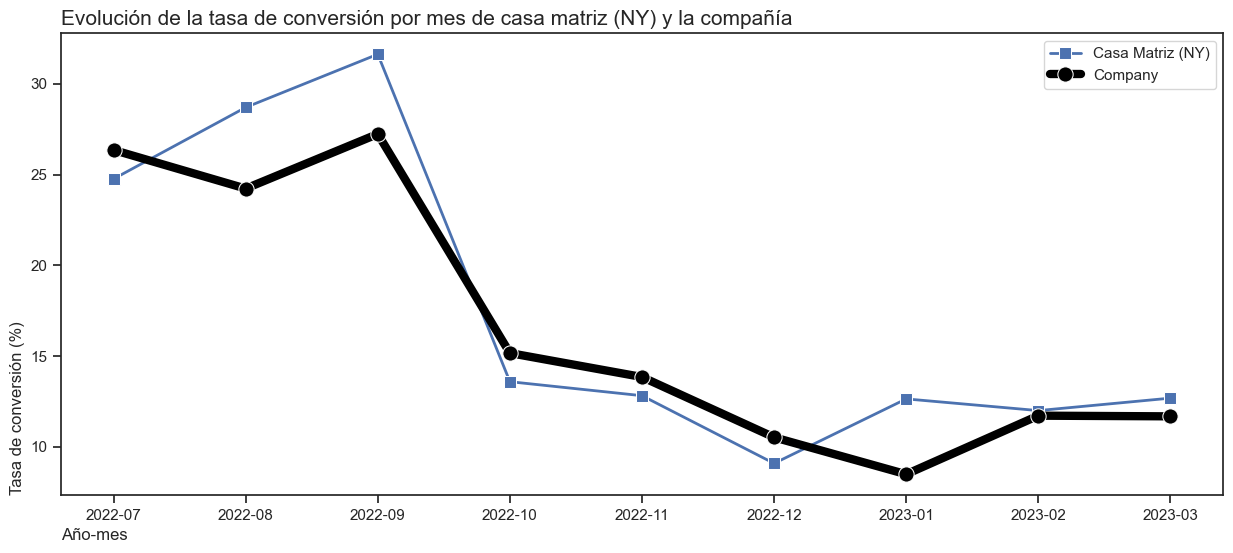

In [147]:
def plot_combined_conversion_rates(casa_matriz_df, company_df, title):
    # Para casa matriz
    casa_matriz_completed_df = casa_matriz_df[casa_matriz_df['Order Funnel State'] == '9-Completed']
    casa_matriz_completed_grouped = casa_matriz_completed_df.groupby(['Year', 'Month']).size().reset_index(name='CasaMatriz_Completed_Count')
    casa_matriz_total_grouped = casa_matriz_df.groupby(['Year', 'Month']).size().reset_index(name='CasaMatriz_Total_Count')
    casa_matriz_conversion_df = pd.merge(casa_matriz_total_grouped, casa_matriz_completed_grouped, on=['Year', 'Month'], how='left').fillna(0)
    casa_matriz_conversion_df['CasaMatriz_Conversion_Rate'] = (casa_matriz_conversion_df['CasaMatriz_Completed_Count'] / casa_matriz_conversion_df['CasaMatriz_Total_Count']) * 100
    casa_matriz_conversion_df['Year_Month'] = casa_matriz_conversion_df['Year'].astype(str) + '-' + casa_matriz_conversion_df['Month'].astype(str).str.zfill(2)

    # Para la compañía en general
    company_completed_df = company_df[company_df['Order Funnel State'] == '9-Completed']
    company_completed_grouped = company_completed_df.groupby(['Year', 'Month']).size().reset_index(name='Company_Completed_Count')
    company_total_grouped = company_df.groupby(['Year', 'Month']).size().reset_index(name='Company_Total_Count')
    company_conversion_df = pd.merge(company_total_grouped, company_completed_grouped, on=['Year', 'Month'], how='left').fillna(0)
    company_conversion_df['Company_Conversion_Rate'] = (company_conversion_df['Company_Completed_Count'] / company_conversion_df['Company_Total_Count']) * 100
    company_conversion_df['Year_Month'] = company_conversion_df['Year'].astype(str) + '-' + company_conversion_df['Month'].astype(str).str.zfill(2)

    plt.figure(figsize=(15, 6))
    sns.set(style="ticks")

    # Grafico casa matriz
    sns.lineplot(x='Year_Month', y='CasaMatriz_Conversion_Rate', data=casa_matriz_conversion_df, lw=2, marker='s', ms=9, label='Casa Matriz (NY)')

    # Grafico la compañía
    sns.lineplot(x='Year_Month', y='Company_Conversion_Rate', data=company_conversion_df, lw=6, marker='o', ms=11, color='black', label='Company')

    plt.title(title, loc='left', fontsize=15)
    plt.xlabel('Año-mes', loc='left')
    plt.ylabel('Tasa de conversión (%)', loc='bottom')
    plt.xticks(rotation=0)
    plt.grid(False)
    plt.legend()
    plt.show()
plot_combined_conversion_rates(NuevaYorkCompleto, df_tz, 'Evolución de la tasa de conversión por mes de casa matriz (NY) y la compañía')


## ¿Existen diferencias en tasas de conversión según los medios de contacto y su disponibilidad?

In [148]:
ny_mail_y_telef = ny[ny['order_has_user_email'] == True]
ny_por_hora_mail_y_telef = ny_mail_y_telef.groupby('local_time_apply').agg(
    totales = ('conversion', 'count'), convertidos = ('conversion', 'sum')
).reset_index()
ny_por_hora_mail_y_telef['tasa_de_conversion_por_hora'] = ny_por_hora_mail_y_telef['convertidos'] / ny_por_hora_mail_y_telef['totales']
ny_por_hora_mail_y_telef['medios_de_contacto'] = 'email y teléfono'
ny_por_hora_mail_y_telef

,local_time_apply,totales,convertidos,tasa_de_conversion_por_hora,medios_de_contacto
0,9,61,17,0.278689,email y teléfono
1,10,96,25,0.260417,email y teléfono
2,11,56,9,0.160714,email y teléfono
3,12,86,18,0.209302,email y teléfono
4,13,70,22,0.314286,email y teléfono
5,14,59,11,0.186441,email y teléfono
6,15,49,13,0.265306,email y teléfono
7,16,48,9,0.187500,email y teléfono
8,17,53,7,0.132075,email y teléfono
9,18,5,3,0.600000,email y teléfono


In [149]:
ny_telef_no_mail = ny[ny['order_has_user_email'] == False]
ny_por_hora_telef_no_mail = ny_telef_no_mail.groupby('local_time_apply').agg(
    totales = ('conversion', 'count'), convertidos = ('conversion', 'sum')
).reset_index()
ny_por_hora_telef_no_mail['tasa_de_conversion_por_hora'] = ny_por_hora_telef_no_mail['convertidos'] / ny_por_hora_telef_no_mail['totales']
ny_por_hora_telef_no_mail['medios_de_contacto'] = 'télefono'
ny_por_hora_telef_no_mail

,local_time_apply,totales,convertidos,tasa_de_conversion_por_hora,medios_de_contacto
0,9,49,12,0.244898,télefono
1,10,54,12,0.222222,télefono
2,11,85,5,0.058824,télefono
3,12,57,6,0.105263,télefono
4,13,79,8,0.101266,télefono
5,14,80,9,0.112500,télefono
6,15,99,8,0.080808,télefono
7,16,74,13,0.175676,télefono
8,17,94,9,0.095745,télefono
9,18,16,1,0.062500,télefono


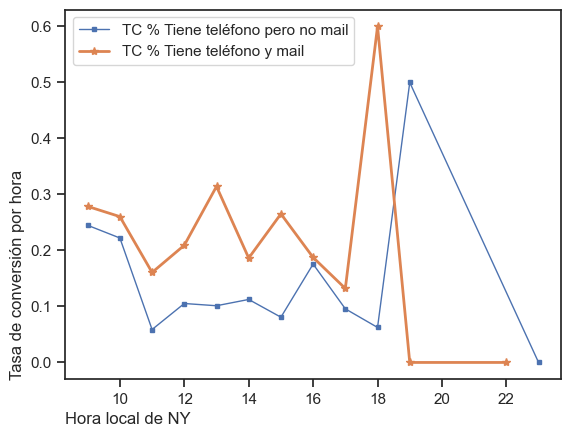

In [150]:
plt.plot(ny_por_hora_telef_no_mail['local_time_apply'], ny_por_hora_telef_no_mail['tasa_de_conversion_por_hora'], label='TC % Tiene teléfono pero no mail',linewidth=1, marker='s', markersize=3)
plt.plot(ny_por_hora_mail_y_telef['local_time_apply'], ny_por_hora_mail_y_telef['tasa_de_conversion_por_hora'], label='TC % Tiene teléfono y mail',linewidth=2, marker='*', markersize=6)
plt.legend()
plt.xlabel('Hora local de NY',loc='left')
plt.ylabel('Tasa de conversión por hora',loc='bottom')
plt.grid(False)

In [155]:
df_tz.columns

Index(['Client Domain', 'User Phone Timezone', 'Created At', 'Email Clicks',
       'Email Opens', 'Emails', 'Expired', 'Order Funnel State', 'Sms',
       'Sms Clicks', 'Sms Opens', 'Platforms Order Group - Order → Manager',
       'Platforms Order Group - Order → Source', 'order_has_user_email',
       'order_has_user_phone', 'etapa_del_funnel', 'Day', 'Month', 'Year',
       'hrs-pyz', 'local_time', 'local_time_apply', 'conversion'],
      dtype='object')

In [156]:
df_tz.head()

,Client Domain,User Phone Timezone,Created At,Email Clicks,Email Opens,Emails,Expired,Order Funnel State,Sms,Sms Clicks,...,order_has_user_email,order_has_user_phone,etapa_del_funnel,Day,Month,Year,hrs-pyz,local_time,local_time_apply,conversion
194,A,EST,2023-01-20 19:03:11.624372+00:00,2,0,4.0,1,6-Employer selected,1.0,1,...,True,True,6,20,1,2023,America/New_York,2023-01-20 14:03:11.624372-05:00,14,0
195,A,EST,2022-07-12 17:44:08.149542+00:00,1,1,1.0,0,9-Completed,1.0,1,...,True,True,9,12,7,2022,America/New_York,2022-07-12 13:44:08.149542-04:00,13,1
196,A,EST,2022-08-08 20:24:56.757669+00:00,1,1,1.0,0,9-Completed,1.0,0,...,True,True,9,8,8,2022,America/New_York,2022-08-08 16:24:56.757669-04:00,16,1
197,A,EST,2022-11-28 17:32:59.758117+00:00,0,4,4.0,1,7-Viewed provider login,1.0,1,...,True,True,7,28,11,2022,America/New_York,2022-11-28 12:32:59.758117-05:00,12,0
198,A,EST,2022-07-07 15:39:00.538025+00:00,4,4,4.0,1,5-Widget loaded,1.0,1,...,True,True,5,7,7,2022,America/New_York,2022-07-07 11:39:00.538025-04:00,11,0


In [161]:
Conversion_por_zona = df_tz.groupby('hrs-pyz').agg(totales=('conversion', 'count'), conversion=('conversion', 'sum')).reset_index().sort_values(by='totales', ascending=False)
Conversion_por_zona['tasa_de_conversion'] = Conversion_por_zona['conversion'] / Conversion_por_zona['totales']
Conversion_por_zona['ordenes_respecto_al_total'] = Conversion_por_zona['totales']/ Conversion_por_zona['totales'].sum()
Conversion_por_zona

,hrs-pyz,totales,conversion,tasa_de_conversion,ordenes_respecto_al_total
1,America/Chicago,2357,340,0.144251,0.615084
4,America/New_York,1277,219,0.171496,0.333246
3,America/Los_Angeles,128,15,0.117188,0.033403
2,America/Denver,54,9,0.166667,0.014092
5,America/Puerto_Rico,8,1,0.125000,0.002088
6,Pacific/Honolulu,5,1,0.200000,0.001305
0,America/Anchorage,3,0,0.000000,0.000783


In [173]:
Conversion_por_zona.columns

Index(['hrs-pyz', 'totales', 'conversion', 'tasa_de_conversion',
       'ordenes_respecto_al_total'],
      dtype='object')

<Axes: title={'center': 'Porcentaje de ordenes respecto al total de los datos por región'}, ylabel='región'>

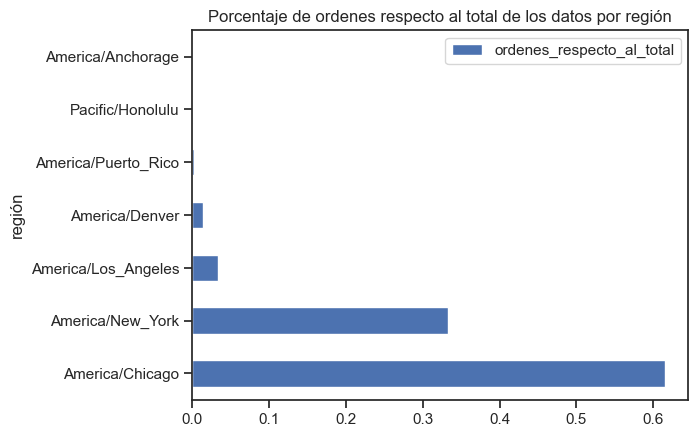

In [180]:
Conversion_por_zona.plot(x='hrs-pyz', y='ordenes_respecto_al_total',kind='barh', title='Porcentaje de ordenes respecto al total de los datos por región', grid=False, ylabel='región')

In [182]:
df_tz.head()

,Client Domain,User Phone Timezone,Created At,Email Clicks,Email Opens,Emails,Expired,Order Funnel State,Sms,Sms Clicks,...,order_has_user_email,order_has_user_phone,etapa_del_funnel,Day,Month,Year,hrs-pyz,local_time,local_time_apply,conversion
194,A,EST,2023-01-20 19:03:11.624372+00:00,2,0,4.0,1,6-Employer selected,1.0,1,...,True,True,6,20,1,2023,America/New_York,2023-01-20 14:03:11.624372-05:00,14,0
195,A,EST,2022-07-12 17:44:08.149542+00:00,1,1,1.0,0,9-Completed,1.0,1,...,True,True,9,12,7,2022,America/New_York,2022-07-12 13:44:08.149542-04:00,13,1
196,A,EST,2022-08-08 20:24:56.757669+00:00,1,1,1.0,0,9-Completed,1.0,0,...,True,True,9,8,8,2022,America/New_York,2022-08-08 16:24:56.757669-04:00,16,1
197,A,EST,2022-11-28 17:32:59.758117+00:00,0,4,4.0,1,7-Viewed provider login,1.0,1,...,True,True,7,28,11,2022,America/New_York,2022-11-28 12:32:59.758117-05:00,12,0
198,A,EST,2022-07-07 15:39:00.538025+00:00,4,4,4.0,1,5-Widget loaded,1.0,1,...,True,True,5,7,7,2022,America/New_York,2022-07-07 11:39:00.538025-04:00,11,0


In [186]:
convertidos_df_tz.columns

Index(['conversiones', 'totales', '%_conversion'], dtype='object')

In [193]:
regiones = df_tz.groupby(['hrs-pyz','local_time_apply'], as_index=True).agg(
    conversiones = ('conversion', 'sum'),
    totales = ('conversion', 'count')
).reset_index()
regiones[(regiones['hrs-pyz']=='America/Chicago') | (regiones['hrs-pyz']=='America/Denver') | (regiones['hrs-pyz']=='America/New_York') |(regiones['hrs-pyz']=='America/Los_Angeles')]

,hrs-pyz,local_time_apply,conversiones,totales
3,America/Chicago,7,0,2
4,America/Chicago,8,35,191
5,America/Chicago,9,40,281
6,America/Chicago,10,32,299
7,America/Chicago,11,30,178
8,America/Chicago,12,47,251
9,America/Chicago,13,35,231
10,America/Chicago,14,34,248
11,America/Chicago,15,40,338
12,America/Chicago,16,37,282


In [192]:
regiones['hrs-pyz'].unique()

array(['America/Anchorage', 'America/Chicago', 'America/Denver',
       'America/Los_Angeles', 'America/New_York', 'America/Puerto_Rico',
       'Pacific/Honolulu'], dtype=object)

In [194]:
df_tz.head()

,Client Domain,User Phone Timezone,Created At,Email Clicks,Email Opens,Emails,Expired,Order Funnel State,Sms,Sms Clicks,...,order_has_user_email,order_has_user_phone,etapa_del_funnel,Day,Month,Year,hrs-pyz,local_time,local_time_apply,conversion
194,A,EST,2023-01-20 19:03:11.624372+00:00,2,0,4.0,1,6-Employer selected,1.0,1,...,True,True,6,20,1,2023,America/New_York,2023-01-20 14:03:11.624372-05:00,14,0
195,A,EST,2022-07-12 17:44:08.149542+00:00,1,1,1.0,0,9-Completed,1.0,1,...,True,True,9,12,7,2022,America/New_York,2022-07-12 13:44:08.149542-04:00,13,1
196,A,EST,2022-08-08 20:24:56.757669+00:00,1,1,1.0,0,9-Completed,1.0,0,...,True,True,9,8,8,2022,America/New_York,2022-08-08 16:24:56.757669-04:00,16,1
197,A,EST,2022-11-28 17:32:59.758117+00:00,0,4,4.0,1,7-Viewed provider login,1.0,1,...,True,True,7,28,11,2022,America/New_York,2022-11-28 12:32:59.758117-05:00,12,0
198,A,EST,2022-07-07 15:39:00.538025+00:00,4,4,4.0,1,5-Widget loaded,1.0,1,...,True,True,5,7,7,2022,America/New_York,2022-07-07 11:39:00.538025-04:00,11,0


In [ ]:
df_tz